<a href="https://colab.research.google.com/github/TuringCollegeSubmissions/kherna-DS.v2.5.3.4.1/blob/main/credit_risk_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Credit Risk Analysis - Machine Learning and Deployment

Install non-native packages.

In [1]:
!pip install optuna
!pip install -q kaggle
!pip install -q Flask joblib scikit-learn xgboost lightgbm imbalanced-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 14.6 MB/s eta 0:00:00


Import necessary packages.

In [2]:
import os
import pickle
import json
import requests
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import duckdb as db

from typing import List, Tuple

from google.colab import files, auth

from sklearn.impute import KNNImputer, IterativeImputer, SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import (
    train_test_split, StratifiedShuffleSplit, StratifiedKFold,
    GridSearchCV, RandomizedSearchCV
)
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score, confusion_matrix,
    classification_report, roc_auc_score, fbeta_score,
    precision_recall_curve, roc_curve, auc
)

from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

import joblib
import optuna
from lightgbm import LGBMClassifier
from lightgbm import early_stopping as lgb_early_stopping
from xgboost import XGBClassifier

warnings.filterwarnings('ignore')


## 1. Import and prepare data for training

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


The database prepared earlier in another notebook is imported.

In [4]:
db_path = '/content/drive/My Drive/Turing/ML Capstone project/home_credit.db'

I am using DuckDB again to run queries.

In [5]:
con = db.connect(db_path)

In [6]:
con.execute('SHOW TABLES').fetchall()

[('application_test',),
 ('application_train',),
 ('bureau',),
 ('bureau_balance',),
 ('bureau_merged_agg',),
 ('bureau_middle',),
 ('card_merged_agg',),
 ('credit_card_balance',),
 ('inst_merged_agg',),
 ('installments_payments',),
 ('pos_cash_balance',),
 ('pos_merged_agg',),
 ('prep_app_merged_history',),
 ('prep_app_merged_history_TEST',),
 ('prep_data',),
 ('prev_app_agg',),
 ('previous_application',)]

Separate the ids from the set for later restoring.

In [7]:
train_ids = con.execute('SELECT SK_ID_CURR FROM prep_app_merged_history').fetchdf()['SK_ID_CURR']

Separate the target values to use later.

In [8]:
train_target = con.execute('SELECT TARGET FROM prep_app_merged_history').fetchdf()['TARGET']

Import training and testing sets.

In [9]:
training_data = con.execute('SELECT * FROM prep_app_merged_history').fetchdf()
testing_data = con.execute('SELECT * FROM prep_app_merged_history_TEST').fetchdf()

Doing double checks as the saved data proved to be still not completely as desired earlier.

In [10]:
training_data.isna().sum()[training_data.isna().sum()>0]

,0
EMERGENCYSTATE_MODE,145755
bureau_earlier_credits_count,44020
bureau_pct_Active,44020
bureau_pct_Closed,44020
bureau_pct_Sold,44020
...,...
NAME_PORTFOLIO_POS,16455
NAME_PRODUCT_TYPE_x-sell,16455
NAME_YIELD_GROUP_low_action,16455
NAME_YIELD_GROUP_low_normal,16455


The high amount of missing values can be explained by the current ID not being present in lower-level tables, thus not having a relevant value.

To correct this error I will impute the missing values or occasionally drop columns with an unreasonably high percventage of missing values.

Drop a mistakenly kept str feature that has already been one-hot encoded.

In [11]:
training_data.drop(columns = 'NAME_CONTRACT_STATUS', inplace= True )

In [12]:
testing_data.drop(columns = 'NAME_CONTRACT_STATUS', inplace= True )

Fill the missing values in the only boolean feature.

In [13]:
training_data.dtypes[training_data.dtypes == 'boolean']

,0
EMERGENCYSTATE_MODE,boolean


In [14]:
training_data['EMERGENCYSTATE_MODE'] = training_data['EMERGENCYSTATE_MODE'].fillna(False)
testing_data['EMERGENCYSTATE_MODE'] = testing_data['EMERGENCYSTATE_MODE'].fillna(False)

## 2. Baseline model

I am using a RandomForestClassifier to determine the most impactful features to avoid wasteful usage of computation capacity.

I decided to train tree forests on random samples for more credible results.

In [15]:
rf_classifier_1 = BalancedRandomForestClassifier(random_state=42)
rf_classifier_2 = BalancedRandomForestClassifier(random_state=1)
rf_classifier_3 = BalancedRandomForestClassifier(random_state=999)

rf_classifiers = [rf_classifier_1, rf_classifier_2, rf_classifier_3]

In [16]:
X, y = training_data.drop(columns='TARGET'), training_data['TARGET']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
def create_random_samples(X_train, y_train, X_test, y_test, num_samples, initial_random_state=None, sample_fraction=0.1):
    """
    Generates multiple random samples (subsets) from the training and testing data, stratified by the target variable.

    Args:
        X_train (pd.DataFrame): Training features.
        y_train (pd.Series): Training target.
        X_test (pd.DataFrame): Testing features.
        y_test (pd.Series): Testing target.
        num_samples (int): The number of random samples to generate.
        initial_random_state (int, optional): Random state for the first sample, defaults to None.
        sample_fraction (float, optional): The fraction of data to include in each sample, defaults to 0.1.

    Returns:
        tuple: A tuple containing four lists:
               - list of sampled X_train DataFrames
               - list of sampled y_train Series
               - list of sampled X_test DataFrames
               - list of sampled y_test Series
    """


    X_train_samples = []
    y_train_samples = []
    X_test_samples = []
    y_test_samples = []

    train_data = pd.concat([X_train, y_train], axis=1)
    test_data = pd.concat([X_test, y_test], axis=1)


    for i in range(num_samples):
        random_state = initial_random_state if i == 0 else None
        splitter = StratifiedShuffleSplit(n_splits=1, test_size=1 - sample_fraction, random_state=random_state)

        for train_index, _ in splitter.split(train_data, train_data['TARGET']):
            train_sample = train_data.iloc[train_index]
            X_train_samples.append(train_sample.drop(columns=['TARGET']))
            y_train_samples.append(train_sample['TARGET'])

        for test_index, _ in splitter.split(test_data, test_data['TARGET']):
            test_sample = test_data.iloc[test_index]
            X_test_samples.append(test_sample.drop(columns=['TARGET']))
            y_test_samples.append(test_sample['TARGET'])

    return X_train_samples, y_train_samples, X_test_samples, y_test_samples

In [18]:
num_samples_to_create = 3
X_train_samples_list, y_train_samples_list, X_test_samples_list, y_test_samples_list = create_random_samples(
    X_train, y_train, X_test, y_test, num_samples=num_samples_to_create, initial_random_state=1
)

print(f"Generated {len(X_train_samples_list)} sets of training and testing samples.")

Generated 3 sets of training and testing samples.


Train the initialized models with the random samples.
Store the feature importances in a new dataframe to determine the relevant features.

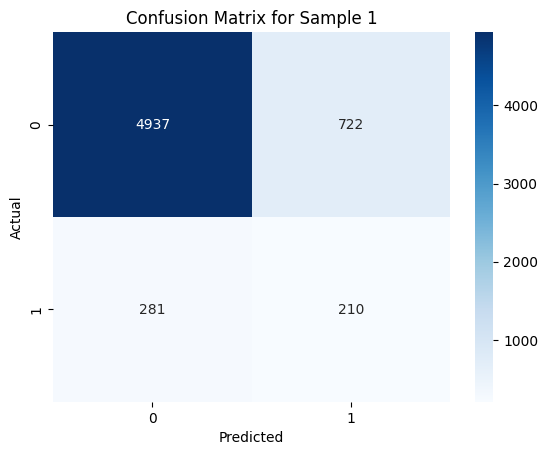

Classification Report for Sample 1:
              precision    recall  f1-score   support

           0       0.95      0.87      0.91      5659
           1       0.23      0.43      0.30       491

    accuracy                           0.84      6150
   macro avg       0.59      0.65      0.60      6150
weighted avg       0.89      0.84      0.86      6150

F1 Score (Positive Class) for Sample 1: 0.2951510892480675


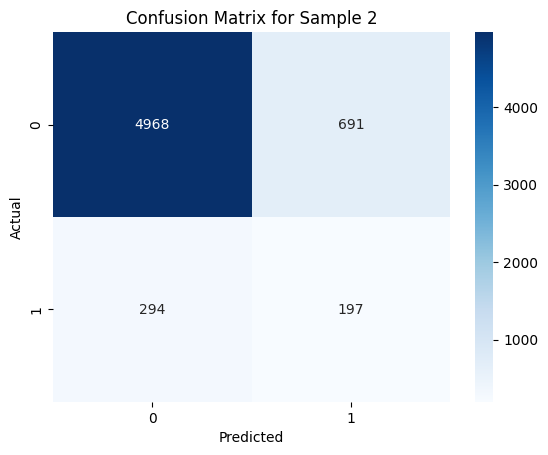

Classification Report for Sample 2:
              precision    recall  f1-score   support

           0       0.94      0.88      0.91      5659
           1       0.22      0.40      0.29       491

    accuracy                           0.84      6150
   macro avg       0.58      0.64      0.60      6150
weighted avg       0.89      0.84      0.86      6150

F1 Score (Positive Class) for Sample 2: 0.2857142857142857


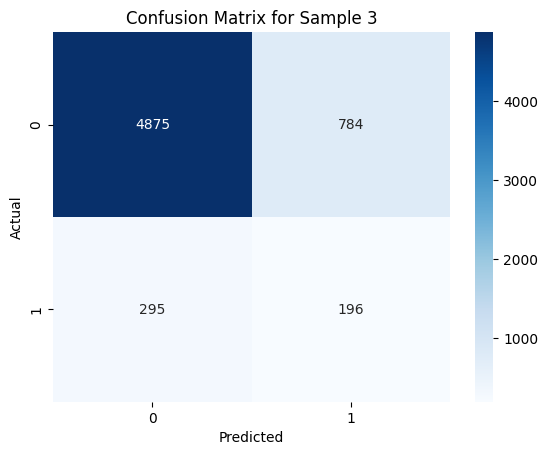

Classification Report for Sample 3:
              precision    recall  f1-score   support

           0       0.94      0.86      0.90      5659
           1       0.20      0.40      0.27       491

    accuracy                           0.82      6150
   macro avg       0.57      0.63      0.58      6150
weighted avg       0.88      0.82      0.85      6150

F1 Score (Positive Class) for Sample 3: 0.2664853840924541


In [19]:
feature_importances = pd.DataFrame(columns=['Feature'])

for i in range(num_samples_to_create):
    rf_classifiers[i].fit(X_train_samples_list[i], y_train_samples_list[i])
    y_pred = rf_classifiers[i].predict(X_test_samples_list[i])

    conf_matrix = confusion_matrix(y_test_samples_list[i], y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for Sample {i + 1}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    print(f"Classification Report for Sample {i + 1}:\n{classification_report(y_test_samples_list[i], y_pred)}")

    f1 = f1_score(y_test_samples_list[i], y_pred, pos_label=1)
    print(f"F1 Score (Positive Class) for Sample {i + 1}: {f1}")

    feature_importances[f'Sample_{i + 1}'] = rf_classifiers[i].feature_importances_

feature_importances['Feature'] = X_train_samples_list[0].columns



As we got very poor F1-scores: around 0.3, I will have to do modifications, as the current models do not capture important patterns, so I will not filter features based on these results.

I did not use the feature importances resulting from this run.

## 3. Possible improvements to data quality

### 3.1. Missing values

Discovering the missing values in the dataset.

In [20]:
training_data.isna().sum()[training_data.isna().sum()>0]

,0
bureau_earlier_credits_count,44020
bureau_pct_Active,44020
bureau_pct_Closed,44020
bureau_pct_Sold,44020
bureau_pct_other,44020
...,...
NAME_PORTFOLIO_POS,16455
NAME_PRODUCT_TYPE_x-sell,16455
NAME_YIELD_GROUP_low_action,16455
NAME_YIELD_GROUP_low_normal,16455


Impute the missing values and indicate them with a flag for predictive power.

In [24]:
cols_with_missing = training_data.columns[training_data.isnull().any()]

missing_indicators = pd.concat(
    [training_data[col].isnull().astype('int8').rename(f'{col}_was_missing') for col in cols_with_missing],
    axis=1
)

training_data = pd.concat([training_data, missing_indicators], axis=1)

imputer = SimpleImputer(strategy='median')
training_data[cols_with_missing] = imputer.fit_transform(training_data[cols_with_missing])

missing_indicators_test = pd.concat(
    [testing_data[col].isnull().astype('int8').rename(f'{col}_was_missing') for col in cols_with_missing],
    axis=1
)
testing_data = pd.concat([testing_data, missing_indicators_test], axis=1)

testing_data[cols_with_missing] = imputer.transform(testing_data[cols_with_missing])


### 3.2. Downcasting for better performance

Downcast numeric types to save memory, which is critical given the amount of data.

In [21]:
training_data = training_data.apply(pd.to_numeric, downcast='float')
training_data = training_data.apply(pd.to_numeric, downcast='integer')

training_data['EMERGENCYSTATE_MODE'] = training_data['EMERGENCYSTATE_MODE'].apply(lambda x: 1 if x is True else (0 if x is False else x))

training_data.dtypes.unique()


array([dtype('int8'), dtype('int16'), dtype('float32'), dtype('int32'),
       dtype('int64'), Int8Dtype(), Int16Dtype(), Int32Dtype()],
      dtype=object)

In [22]:
testing_data = testing_data.apply(pd.to_numeric, downcast='float')
testing_data = testing_data.apply(pd.to_numeric, downcast='integer')

testing_data['EMERGENCYSTATE_MODE'] = testing_data['EMERGENCYSTATE_MODE'].apply(lambda x: 1 if x is True else (0 if x is False else x))

### 3.3. Clean column names

Clean column names from confusing characters - LGBM is sensitive.

In [23]:
def clean_column_names(df):
    df.columns = df.columns.str.replace(r'[\"\'{}\[\]:, ]', '', regex=True)
    return df

training_data = clean_column_names(training_data)
testing_data = clean_column_names(testing_data)

### 3.4. Creating new baseline after improvements

Create baseline model using the imputed dataset.

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.87      0.91     56538
           1       0.23      0.43      0.30      4965

    accuracy                           0.84     61503
   macro avg       0.59      0.65      0.60     61503
weighted avg       0.89      0.84      0.86     61503

F1-score (macro): 0.6043836565651519
F1-score (pos class): 0.30070663961379696


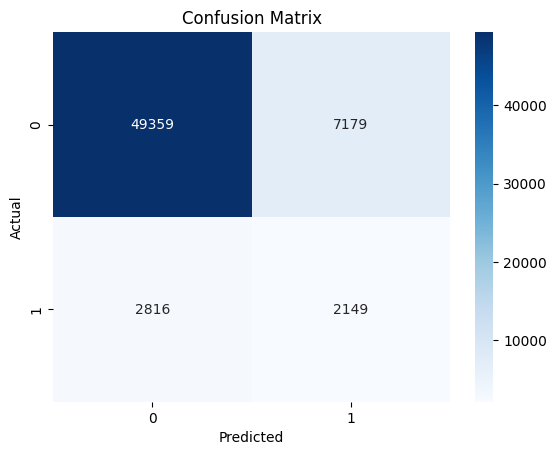

In [26]:
X = training_data.drop(columns=['TARGET', 'SK_ID_CURR'])
y = training_data['TARGET']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

clf = BalancedRandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))
print("F1-score (macro):", f1_score(y_test, y_pred, average='macro'))
print("F1-score (pos class):", f1_score(y_test, y_pred, pos_label=1))

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


The performance is still really poor after imputing the missing values.

Other measures will be necessary.

### 3.5. Compensating imbalance using SMOTE

In [28]:
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)

## 4. Model selection

Subsample from the training set, so we can deetrmine faster which models show potential for actual training and CV.

In [30]:
X_train_sample, X_test_sample, y_train_sample, y_test_sample = train_test_split(X_res, y_res, test_size=0.85, stratify=y_res, random_state=42)

Create a tracker table for the results of the training.

In [31]:
sample_train_results = pd.DataFrame()

Save the trained models for later loading to save time on reruns.

In [32]:
model_save_path = '/content/drive/My Drive/Turing/ML Capstone project/trained_models'

os.makedirs(model_save_path, exist_ok=True)

In [ ]:
def train_or_load_model(model, save_name: str, X_train, y_train, model_save_path: str):
    save_path = os.path.join(model_save_path, save_name)

    if not os.path.exists(save_path):
        model.fit(X_train, y_train)
        joblib.dump(model, save_path)
    else:
        model = joblib.load(save_path)

    return model

In [ ]:
def evaluate_and_add_result(df, model, model_name, X_test, y_test, pos_label=1):
    y_pred = model.predict(X_test)
    f1 = round(f1_score(y_test, y_pred, pos_label=pos_label), 4)
    new_row = pd.DataFrame({'model': [model_name], 'F1-score': [f1]})
    return pd.concat([df, new_row], ignore_index=True)

### 4.1. Logistic Regression

In [33]:
logreg_model = train_or_load_model(
    model=LogisticRegression(max_iter=1000, solver='saga'),
    save_name='logreg_model.pkl',
    X_train=X_train_sample,
    y_train=y_train_sample,
    model_save_path=model_save_path
)

In [ ]:
sample_train_results = evaluate_and_add_result(
    df=sample_train_results,
    model=logreg_model,
    model_name='Logistic Regression',
    X_test=X_test_sample,
    y_test=y_test_sample
)

## 4.2. Balanced Random Forest

In [38]:
balanced_forest = train_or_load_model(
    model=BalancedRandomForestClassifier(random_state=42, n_jobs=-1),
    save_name='balanced_forest.pkl',
    X_train=X_train_sample,
    y_train=y_train_sample,
    model_save_path=model_save_path
)

In [39]:
sample_train_results = evaluate_and_add_result(
    df=sample_train_results,
    model=balanced_forest,
    model_name='Balanced Random Forest',
    X_test=X_test_sample,
    y_test=y_test_sample
)

## 4.3. XGBoost

In [40]:
xgb = train_or_load_model(
    model=XGBClassifier(use_label_encoder=False, eval_metric='f1', random_state=42, n_jobs=-1),
    save_name='xgb.pkl',
    X_train=X_train_sample,
    y_train=y_train_sample,
    model_save_path=model_save_path
)

In [41]:
sample_train_results = evaluate_and_add_result(
    df=sample_train_results,
    model=xgb,
    model_name='XGBoost',
    X_test=X_test_sample,
    y_test=y_test_sample
)

## 4.4. LightGBM

In [42]:
lgbm = train_or_load_model(
    model=LGBMClassifier(objective='binary', metric='f1', random_state=42, n_jobs=-1),
    save_name='lgbm.pkl',
    X_train=X_train_sample,
    y_train=y_train_sample,
    model_save_path=model_save_path
)

In [43]:
sample_train_results = evaluate_and_add_result(
    df=sample_train_results,
    model=lgbm,
    model_name='LGBM',
    X_test=X_test_sample,
    y_test=y_test_sample
)

## 4.5. K-nearest Neighbors

In [44]:
knn = train_or_load_model(
    model=KNeighborsClassifier(),
    save_name='knn.pkl',
    X_train=X_train_sample,
    y_train=y_train_sample,
    model_save_path=model_save_path
)

In [45]:
sample_train_results = evaluate_and_add_result(
    df=sample_train_results,
    model=knn,
    model_name='KNN',
    X_test=X_test_sample,
    y_test=y_test_sample
)

Select the best models based on the F1-score for further training on the complete dataset including cross validation and tuning.

Due to the banking setting I prioritized the F1-score, even though the Kaggle competition rewards ROC, because:
- Rewards models that don’t miss many actual positives (high recall),
- While also avoiding too many false alarms (high precision).

In [46]:
sample_train_results.sort_values(by='F1-score', ascending=False)

,"(model,)","(F1-score,)",model,F1-score
3,NaN,NaN,LGBM,0.953100
2,NaN,NaN,XGBoost,0.952100
1,NaN,NaN,Balanced Random Forest,0.945800
4,NaN,NaN,K-Nearest Neighbors,0.749900
0,NaN,NaN,Logistic Regression,0.595712


The best performing models were:
- Balanced Random Forest
- XGBoost
- LGBM

I will use these type of models for Hyperparameter Tuning using Optuna trials.

# 5. Hyperparameter Tuning

Define the chosen models and their parameter grids.

In [47]:
models = {
    'Balanced Random Forest': BalancedRandomForestClassifier(random_state=42, n_jobs=-1),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='f1', random_state=42, n_jobs=-1),
    'LGBM': LGBMClassifier(objective='binary', metric='f1', random_state=42, n_jobs=-1),
}

param_grids = {
    'Balanced Random Forest': {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    },
    'XGBoost': {
        'n_estimators': [100, 200],
        'max_depth': [3, 6, 10],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    },
    'LGBM': {
        'n_estimators': [100, 200],
        'max_depth': [-1, 10, 20],
        'learning_rate': [0.01, 0.1, 0.2],
        'num_leaves': [31, 50, 100],
        'subsample': [0.8, 1.0]
    },
}



In [48]:
def tune_and_evaluate_models(models, param_grids, X_train, y_train, X_test, y_test, model_save_path, scoring='recall', n_trials=15, threshold=0.3):
    best_models = {}
    results = []

    X_train_sub, X_val, y_train_sub, y_val = train_test_split(
        X_train, y_train, test_size=0.2, stratify=y_train, random_state=42
    )

    smote = SMOTE(random_state=42)
    X_train_sub_res, y_train_sub_res = smote.fit_resample(X_train_sub, y_train_sub)

    for name, base_model in models.items():
        file_name = f'{name.replace(" ", "_").lower()}_model_optuned.pkl'
        full_path = os.path.join(model_save_path, file_name)

        if os.path.exists(full_path):
            print(f"📦 Loading {name} from saved model at {full_path}")
            with open(full_path, 'rb') as f:
                best_model = pickle.load(f)
        else:
            print(f"🔍 Tuning {name}...")

            if name == 'Gradient Boosting':
                grid = RandomizedSearchCV(
                    base_model,
                    param_distributions=param_grids[name],
                    n_iter=10,
                    scoring=scoring,
                    cv=3,
                    n_jobs=-1,
                    random_state=42
                )
                grid.fit(X_train, y_train)
                best_model = grid.best_estimator_
                print(f"✅ GridSearch best params for {name}: {grid.best_params_}")
            else:
                def objective(trial):
                    params = {
                        key: trial.suggest_categorical(key, values)
                        for key, values in param_grids[name].items()
                    }
                    model = base_model.__class__(**params)
                    model.set_params(random_state=42)
                    if hasattr(model, 'n_jobs'):
                        model.set_params(n_jobs=-1)

                    if name == 'LGBM':
                        model.set_params(objective='binary')
                        model.fit(
                            X_train_sub_res,
                            y_train_sub_res,
                            eval_set=[(X_val, y_val)],
                            eval_metric='binary_error',
                            callbacks=[lgb_early_stopping(stopping_rounds=30, verbose=False)]
                        )
                        y_prob = model.predict_proba(X_val)[:, 1]
                    else:
                        model.fit(X_train_sub_res, y_train_sub_res)
                        y_prob = model.predict_proba(X_val)[:, 1]

                    y_pred = (y_prob >= threshold).astype(int)
                    return recall_score(y_val, y_pred)

                study = optuna.create_study(direction='maximize')
                study.optimize(objective, n_trials=n_trials)

                best_params = study.best_params
                print(f"✅ Optuna best params for {name}: {best_params}")

                best_model = base_model.__class__(**best_params)
                best_model.set_params(random_state=42)
                if hasattr(best_model, 'n_jobs'):
                    best_model.set_params(n_jobs=-1)

                if name == 'LGBM':
                    best_model.set_params(objective='binary')
                    best_model.fit(
                        X_train_sub_res,
                        y_train_sub_res,
                        eval_set=[(X_val, y_val)],
                        eval_metric='binary_error',
                        callbacks=[lgb_early_stopping(stopping_rounds=30, verbose=False)]
                    )
                else:
                    best_model.fit(X_train_sub_res, y_train_sub_res)

            with open(full_path, 'wb') as f:
                pickle.dump(best_model, f)
            print(f"💾 Saved {name} model to {full_path}")

        best_models[name] = best_model
        y_scores = best_model.predict_proba(X_test)[:, 1]
        y_pred = (y_scores >= threshold).astype(int)

        f1 = f1_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_scores)

        results.append({
            'Model': name,
            'F1 Score': round(f1, 4),
            'Precision': round(precision, 4),
            'Recall': round(recall, 4),
            'ROC AUC': round(roc_auc, 4),
            'Threshold': threshold
        })

        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(4, 3))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'{name} - Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.tight_layout()
        plt.show()

        fpr, tpr, _ = roc_curve(y_test, y_scores)
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(5, 4))
        plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
        plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
        plt.title(f'{name} - ROC Curve')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend()
        plt.tight_layout()
        plt.show()

        precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_scores)
        pr_auc = auc(recall_vals, precision_vals)

        plt.figure(figsize=(5, 4))
        plt.plot(recall_vals, precision_vals, label=f'AUC = {pr_auc:.4f}')
        plt.title(f'{name} - Precision-Recall Curve')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.legend()
        plt.tight_layout()
        plt.show()

    results_df = pd.DataFrame(results).sort_values(by='Recall', ascending=False).reset_index(drop=True)
    return best_models, results_df


📦 Loading Balanced Random Forest from saved model at /content/drive/My Drive/Turing/ML Capstone project/trained_models/balanced_random_forest_model_optuned.pkl


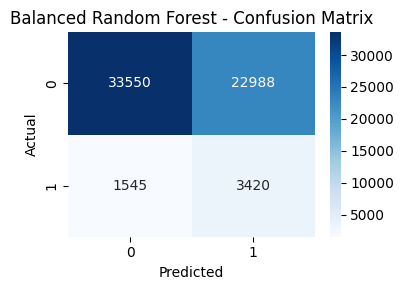

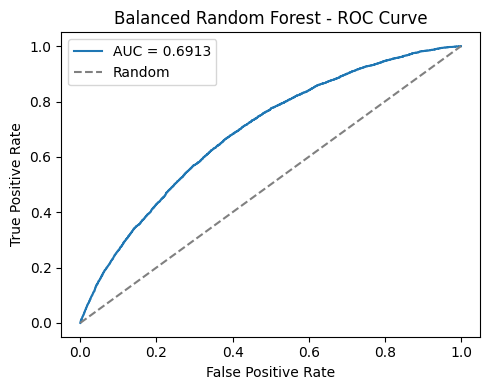

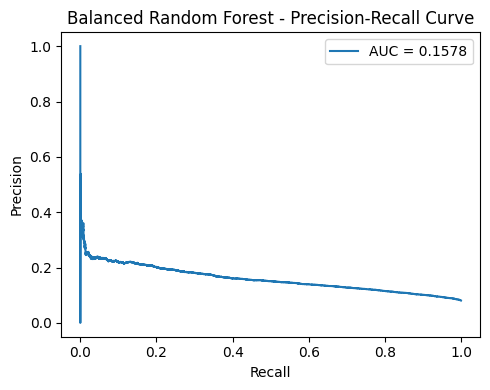

📦 Loading XGBoost from saved model at /content/drive/My Drive/Turing/ML Capstone project/trained_models/xgboost_model_optuned.pkl


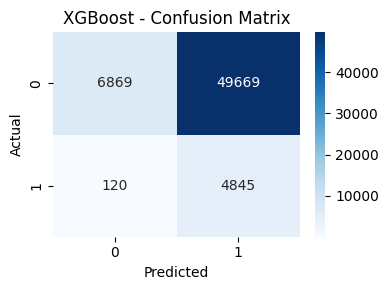

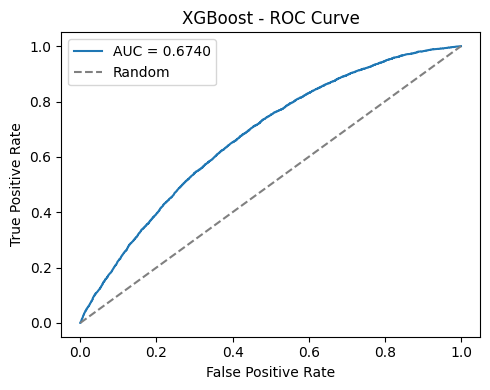

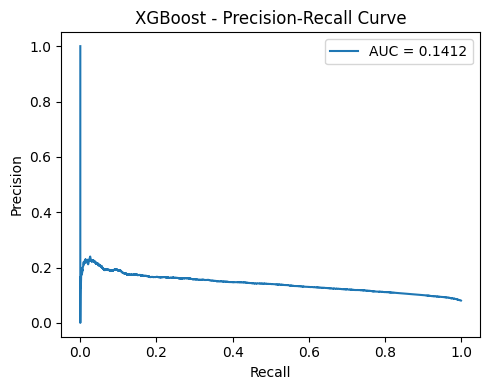

📦 Loading LGBM from saved model at /content/drive/My Drive/Turing/ML Capstone project/trained_models/lgbm_model_optuned.pkl


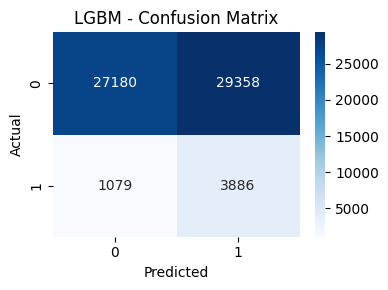

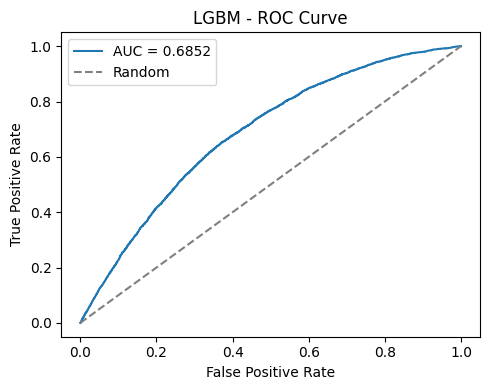

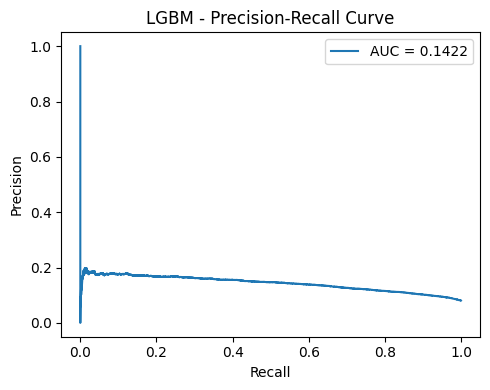

In [49]:
best_models, results_df = tune_and_evaluate_models(models, param_grids, X_train, y_train, X_test, y_test, model_save_path)

# 6. Ensembling

I used a soft voting ensemble to get the results as the probability of defaulting.

[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.346958 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 38185
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 496
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432482
[LightGBM] [Info] Start training from score -2.432482
💾 Saved voting_ensemble model to /content/drive/My Drive/Turing/ML Capstone project/trained_models/voting_ensemble.pkl

🧠 Voting Classifier Performance:
Accuracy:   0.9193
F1 Score:   0.0000
Precision:  0.0000
Recall:     0.0000
ROC AUC:    0.7572

📋 Classification Report for Voting Classifier:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56538
           1       0.00      0.00      0.00      4965

    accuracy                           0.9

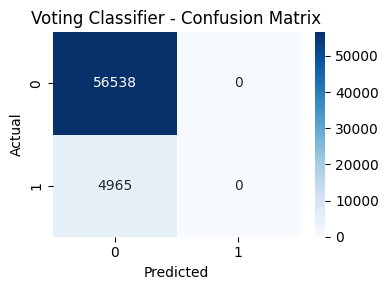

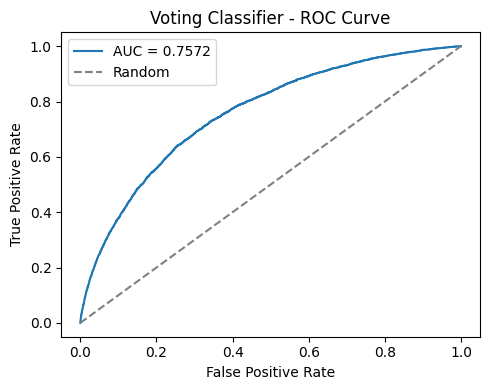

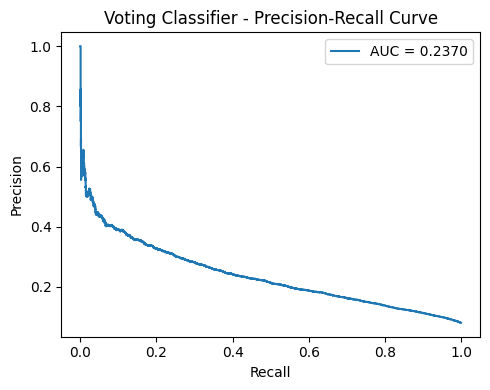

In [50]:
estimators = [(name, model) for name, model in best_models.items()]
voting_clf = VotingClassifier(estimators=estimators, voting='soft')

voting_clf.fit(X_train, y_train)

file_name = 'voting_ensemble.pkl'
full_path = os.path.join(model_save_path, file_name)
with open(full_path, 'wb') as f:
    pickle.dump(voting_clf, f)
print(f"💾 Saved voting_ensemble model to {full_path}")

y_pred_voting = voting_clf.predict(X_test)
y_scores_voting = voting_clf.predict_proba(X_test)[:, 1]

voting_accuracy = accuracy_score(y_test, y_pred_voting)
voting_f1 = f1_score(y_test, y_pred_voting)
voting_precision = precision_score(y_test, y_pred_voting)
voting_recall = recall_score(y_test, y_pred_voting)
voting_roc_auc = roc_auc_score(y_test, y_scores_voting)

print("\n🧠 Voting Classifier Performance:")
print(f"Accuracy:   {voting_accuracy:.4f}")
print(f"F1 Score:   {voting_f1:.4f}")
print(f"Precision:  {voting_precision:.4f}")
print(f"Recall:     {voting_recall:.4f}")
print(f"ROC AUC:    {voting_roc_auc:.4f}")

print("\n📋 Classification Report for Voting Classifier:")
print(classification_report(y_test, y_pred_voting))

cm_voting = confusion_matrix(y_test, y_pred_voting)
plt.figure(figsize=(4, 3))
sns.heatmap(cm_voting, annot=True, fmt='d', cmap='Blues')
plt.title('Voting Classifier - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

fpr, tpr, _ = roc_curve(y_test, y_scores_voting)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.title('Voting Classifier - ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.tight_layout()
plt.show()

precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_scores_voting)
pr_auc = auc(recall_vals, precision_vals)
plt.figure(figsize=(5, 4))
plt.plot(recall_vals, precision_vals, label=f'AUC = {pr_auc:.4f}')
plt.title('Voting Classifier - Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.tight_layout()
plt.show()



# 7. Kaggle Competition Submission

My final submission received a 0.747 ROC score.

For more information about the competition see:

https://www.kaggle.com/competitions/home-credit-default-risk/overview

In [51]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kataherndi","key":"fbcc30c1c4e33978061e301299c38a95"}'}

In [52]:
test_id = testing_data['SK_ID_CURR']

In [54]:
test_records = testing_data.loc[testing_data['SK_ID_CURR'].isin(test_id)].drop(columns = ['SK_ID_CURR'])

In [55]:
test_results = voting_clf.predict_proba(testing_data.drop(columns=['SK_ID_CURR']))[:, 1]

In [56]:
test_frame = pd.DataFrame({'SK_ID_CURR': test_id, 'TARGET': test_results})

In [57]:
test_frame.to_csv('submission_threshold.csv', index=False)

In [58]:
!kaggle competitions submit -c home-credit-default-risk -f submission_threshold.csv -m "submission after modified threshold"

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 4, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.11/dist-packages/kaggle/__init__.py", line 6, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.11/dist-packages/kaggle/api/kaggle_api_extended.py", line 434, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.config/kaggle. Or use the environment method. See setup instructions at https://github.com/Kaggle/kaggle-api/


# 8. Deployment

Save final model.

In [79]:
joblib.dump(voting_clf, "model.joblib")

['model.joblib']

Create code for the Flask app.

In [80]:
flask_code = '''
from flask import Flask, request, jsonify
import joblib
import numpy as np

app = Flask(__name__)
model = joblib.load("model.joblib")

@app.route("/predict", methods=["POST"])
def predict():
    data = request.get_json()
    if not data or "instances" not in data:
        return jsonify({"error": "Missing 'instances' key"}), 400

    try:
        instances = np.array(data["instances"])
        preds = model.predict_proba(instances)[:, 1]
        return jsonify({"predictions": preds.tolist()})
    except Exception as e:
        return jsonify({"error": str(e)}), 500

@app.route("/", methods=["GET"])
def health():
    return "Voting model is running!", 200
'''
with open("app.py", "w") as f:
    f.write(flask_code.strip())


Save requirements.

In [81]:
reqs = '''
Flask
joblib
scikit-learn
xgboost
lightgbm
imbalanced-learn
numpy
'''
with open("requirements.txt", "w") as f:
    f.write(reqs.strip())


Create docker file.

In [82]:
dockerfile = '''
FROM python:3.10-slim

# Install system dependencies required for LightGBM and other ML libraries
RUN apt-get update && apt-get install -y \
    # Core dependencies for LightGBM
    libgomp1 \
    # Build tools (needed if pip needs to compile)
    build-essential \
    cmake \
    # Additional libraries that might be needed
    libglib2.0-0 \
    libsm6 \
    libxext6 \
    libxrender-dev \
    libgl1-mesa-glx \
    # Clean up
    && rm -rf /var/lib/apt/lists/*

WORKDIR /app

# Copy requirements first for better caching
COPY requirements.txt .

# Install Python dependencies
# Use --no-binary :all: for lightgbm to ensure it compiles with the right dependencies
RUN pip install --no-cache-dir -r requirements.txt

# Copy application code
COPY . .

# Set environment variable for port
ENV PORT 8080

# Run the application
CMD ["python", "app.py"]
'''
with open("Dockerfile", "w") as f:
    f.write(dockerfile.strip())


Connect to Google CLoud.

In [84]:
auth.authenticate_user()

Navigate to project.

In [85]:
PROJECT_ID = "turing-final-461008"
SERVICE_NAME = "voting-api"
REGION = "us-central1"
IMAGE = f"gcr.io/{PROJECT_ID}/{SERVICE_NAME}"


In [86]:
!gcloud config set project {PROJECT_ID}
!gcloud services enable run.googleapis.com
!gcloud services enable cloudbuild.googleapis.com


Updated property [core/project].


Build and deploy.

In [88]:
!gcloud builds submit --tag {IMAGE}
!gcloud run deploy {SERVICE_NAME} \
  --image {IMAGE} \
  --platform managed \
  --region {REGION} \
  --allow-unauthenticated


Creating temporary archive of 5 file(s) totalling 652.2 MiB before compression.
Uploading tarball of [.] to [gs://turing-final-461008_cloudbuild/source/1748278037.216995-52c0886384c848e7875fcd2ddfc01fa7.tgz]
Created [https://cloudbuild.googleapis.com/v1/projects/turing-final-461008/locations/global/builds/b7c28c83-d7d9-4537-a986-ed423d656280].
Logs are available at [ https://console.cloud.google.com/cloud-build/builds/b7c28c83-d7d9-4537-a986-ed423d656280?project=607573225867 ].
Waiting for build to complete. Polling interval: 1 second(s).
 REMOTE BUILD OUTPUT
starting build "b7c28c83-d7d9-4537-a986-ed423d656280"

FETCHSOURCE
Fetching storage object: gs://turing-final-461008_cloudbuild/source/1748278037.216995-52c0886384c848e7875fcd2ddfc01fa7.tgz#1748278438034134
Copying gs://turing-final-461008_cloudbuild/source/1748278037.216995-52c0886384c848e7875fcd2ddfc01fa7.tgz#1748278438034134...
|
Operation completed over 1 objects/245.2 MiB.
BUILD
Already have image (with digest): gcr.io/cloud-

Save URL.

In [89]:
url = "https://voting-api-607573225867.us-central1.run.app"

Test with a single instance.

In [100]:
test_instance = testing_data.drop(columns='SK_ID_CURR').iloc[600].tolist()
data = {"instances": [test_instance]}

url = "https://voting-api-607573225867.us-central1.run.app/predict"
headers = {"Content-Type": "application/json"}

response = requests.post(url, headers=headers, data=json.dumps(data))

print("Status code:", response.status_code)

try:
    print("Response JSON:", response.json())
except Exception:
    print("Raw response:", response.text)


Status code: 200
Response JSON: {'predictions': [0.16557907368145452]}


Save multiple instances into json file for batch prediction.

In [104]:
instances = testing_data.drop(columns="SK_ID_CURR").iloc[:5].values.tolist()

data = {"instances": instances}

with open("test_instances.json", "w") as f:
    json.dump(data, f)

from google.colab import files
files.download("test_instances.json")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# [**Postman presentation**](https://kata-6975389.postman.co/workspace/16f4862b-9df5-4f49-8543-5c6b96d5b9e3/request/45335143-4eeff57c-59af-4775-aae9-3171b0f1b6e4?tab=body)



# 9. Improvements

- Cleaner data preparation
  - I had to do extra steps to fix mistakes before training

- Better feature engineering
  - generate more features and then choose good ones
  - make more thorough decisions on what to keep

- Improved pipeline structure
  - include everything into pipelines for a robust solution

- Statistical inference

- Alternative solution - separate models for:
  - Client with historical data
  - First applicant
